In [11]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [16]:
import nltk

In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [18]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
db = pd.read_csv('rev.csv')

In [20]:
db

,Unnamed: 0,title,rating,review
0,0,Black Panther: Wakanda Forever,6.0,Not what I expected...:I am conflicted with t...
1,1,Black Panther: Wakanda Forever,8.0,I liked it a lot:Phase 4's MCU comes to a clo...
2,2,Black Panther: Wakanda Forever,6.0,"I Yield:First of all, RIP to Chadwick Boseman..."
3,3,Black Panther: Wakanda Forever,9.0,A Fantastic Emotional and Mature Marvel Fil...
4,4,Black Panther: Wakanda Forever,8.0,Pays an appropriately sombre tribute to its r...
...,...,...,...,...
1126,1126,Alien,10.0,This Ageless Silent Haunted House Floating ...
1127,1127,Alien,10.0,Original and terrifying sci fi terror:Alien i...
1128,1128,Alien,NaN,Exemplary horror (spoilers):What makes Alien ...
1129,1129,Alien,9.0,The original masterpiece that launched a dyna...


Roberta

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [34]:
db.rename(columns={'Unnamed: 0':'index'}, inplace=True)

In [23]:
def polarity_scores_roberta(text):
    etext = tokenizer(text, return_tensors='pt')
    output = model(**etext)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [24]:
sent = SentimentIntensityAnalyzer()

In [25]:

res = {}
error =[]
for i, row in tqdm(db.iterrows(), total=len(db)):
    try:
        text = row['review']
        id = row['id']
        vader_result = sent.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[id] = both
    except RuntimeError:
        print(f'Broke for id {id}')
        error.append(id)

  0%|          | 0/1131 [00:00<?, ?it/s]

Broke for id 2
Broke for id 3
Broke for id 4
Broke for id 7
Broke for id 10
Broke for id 11
Broke for id 15
Broke for id 19
Broke for id 22
Broke for id 32
Broke for id 38
Broke for id 44
Broke for id 47
Broke for id 48
Broke for id 55
Broke for id 56
Broke for id 58
Broke for id 64
Broke for id 65
Broke for id 79
Broke for id 81
Broke for id 83
Broke for id 94
Broke for id 104
Broke for id 107
Broke for id 111
Broke for id 117
Broke for id 127
Broke for id 134
Broke for id 135
Broke for id 136
Broke for id 150
Broke for id 153
Broke for id 154
Broke for id 155
Broke for id 156
Broke for id 157
Broke for id 159
Broke for id 162
Broke for id 164
Broke for id 165
Broke for id 167
Broke for id 169
Broke for id 170
Broke for id 175
Broke for id 182
Broke for id 189
Broke for id 201
Broke for id 209
Broke for id 211
Broke for id 214
Broke for id 215
Broke for id 217
Broke for id 219
Broke for id 224
Broke for id 232
Broke for id 243
Broke for id 245
Broke for id 246
Broke for id 248
Broke f

In [26]:
results_df = pd.DataFrame(res).T

In [27]:
results_df = results_df.reset_index().rename(columns={'index': 'index'})

In [53]:
results_df

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,title,rating,review
0,0,0.076,0.748,0.176,0.9872,0.325749,0.430216,0.244035,Black Panther: Wakanda Forever,6.0,Not what I expected...:I am conflicted with t...
1,1,0.084,0.657,0.259,0.9974,0.108927,0.338390,0.552683,Black Panther: Wakanda Forever,8.0,I liked it a lot:Phase 4's MCU comes to a clo...
2,5,0.130,0.773,0.098,-0.9116,0.703267,0.249116,0.047617,Black Panther: Wakanda Forever,6.0,Overblown and Oversaturated Airplane Movie:At...
3,6,0.116,0.762,0.122,0.6857,0.598546,0.318510,0.082944,Black Panther: Wakanda Forever,NaN,Bad editing ruined it; the stellar score and ...
4,8,0.042,0.713,0.246,0.9895,0.153455,0.424482,0.422062,Black Panther: Wakanda Forever,7.0,Not the Black Panther we were promised:The mo...
...,...,...,...,...,...,...,...,...,...,...,...
876,1119,0.104,0.742,0.154,0.8951,0.094403,0.289488,0.616110,Alien,9.0,The start of a great anthology:Alien has a sl...
877,1125,0.128,0.826,0.046,-0.7096,0.340016,0.336236,0.323749,Alien,10.0,After 40 years it still scares the hell out o...
878,1126,0.104,0.835,0.062,-0.9510,0.465169,0.467208,0.067622,Alien,10.0,This Ageless Silent Haunted House Floating ...
879,1127,0.066,0.693,0.241,0.9814,0.004260,0.031202,0.964538,Alien,10.0,Original and terrifying sci fi terror:Alien i...


In [38]:
db.drop(error, axis=0, inplace= True)

In [46]:
db.rename(columns={'id':'index'}, inplace = True)

In [48]:
results_df= results_df.merge(db, how='left')

In [49]:
results_df

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,title,rating,review
0,0,0.076,0.748,0.176,0.9872,0.325749,0.430216,0.244035,Black Panther: Wakanda Forever,6.0,Not what I expected...:I am conflicted with t...
1,1,0.084,0.657,0.259,0.9974,0.108927,0.338390,0.552683,Black Panther: Wakanda Forever,8.0,I liked it a lot:Phase 4's MCU comes to a clo...
2,5,0.130,0.773,0.098,-0.9116,0.703267,0.249116,0.047617,Black Panther: Wakanda Forever,6.0,Overblown and Oversaturated Airplane Movie:At...
3,6,0.116,0.762,0.122,0.6857,0.598546,0.318510,0.082944,Black Panther: Wakanda Forever,NaN,Bad editing ruined it; the stellar score and ...
4,8,0.042,0.713,0.246,0.9895,0.153455,0.424482,0.422062,Black Panther: Wakanda Forever,7.0,Not the Black Panther we were promised:The mo...
...,...,...,...,...,...,...,...,...,...,...,...
876,1119,0.104,0.742,0.154,0.8951,0.094403,0.289488,0.616110,Alien,9.0,The start of a great anthology:Alien has a sl...
877,1125,0.128,0.826,0.046,-0.7096,0.340016,0.336236,0.323749,Alien,10.0,After 40 years it still scares the hell out o...
878,1126,0.104,0.835,0.062,-0.9510,0.465169,0.467208,0.067622,Alien,10.0,This Ageless Silent Haunted House Floating ...
879,1127,0.066,0.693,0.241,0.9814,0.004260,0.031202,0.964538,Alien,10.0,Original and terrifying sci fi terror:Alien i...


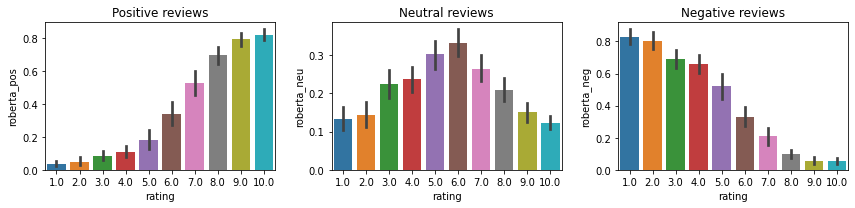

In [52]:
fig, RobertaPlot = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='rating', y='roberta_pos',ax=RobertaPlot[0])
sns.barplot(data=results_df, x='rating', y='roberta_neu', ax=RobertaPlot[1])
sns.barplot(data=results_df, x='rating', y='roberta_neg', ax=RobertaPlot[2])
RobertaPlot[0].set_title('Positive reviews')
RobertaPlot[1].set_title('Neutral reviews')
RobertaPlot[2].set_title('Negative reviews')
plt.tight_layout()
plt.show()